<center>
<img src="https://raw.githubusercontent.com/dvgodoy/PyTorch101_ODSC_Europe2020/master/images/linear_dogs.jpg" width="800">

# Основы глубинного обучения: домашнее задание 4
</center>

## Общая информация

__Дата выдачи:__ 09.12.2023

__Дедлайн:__ 23:59MSK 18.12.2023

В случае этой домашки мягкий дедлан совпадает с жёстким.

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 5.2 балла (3 основных балла и ещё 2.2 бонусных).

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

In [1]:
import gc
import os
import re
import tqdm
import math
import random
import warnings
import collections

import nltk
import torch
import numpy
import wandb
import pandas
import transformers
import pytorch_lightning
import matplotlib.pyplot as plt

device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

RANDOM_STATE = 42
def set_random_seed(seed: int) -> None:
    random.seed(seed)
    numpy.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    pytorch_lightning.seed_everything(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
def fix_random() -> None:
    return set_random_seed(RANDOM_STATE)
fix_random()

warnings.filterwarnings("ignore")

Seed set to 42


cuda


In [2]:
wandb.login(anonymous = "allow")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: ttpo100ajiex (hse-iad). Use `wandb login --relogin` to force relogin


True

## Описание данных

Данные можно [скачать с гугл-диска.](https://drive.google.com/drive/folders/11oCcLplWtp_qm-WuEbfCFP_Mz5K_z3ps?usp=sharing) Если вы делаете задание в колабе, то строчки ниже сами скачают вам данные.

В таблице `ria_news.tsv`  лежат данные о новостях, вышедших на сайте РИА-НОВОСТИ с 15 марта 2018 года по 31 декабря 2018 года.

- `href` - уникальный идентификатор новости (ссылка на неё)
- `date` - дата публикации новости
- `time` - время публикации новости
- `title` - заголовок новости
- `snippet` - краткое описание новости
- `text` - текст новости
- `category` - категория новости
- `keywords` - ключевые слова (подкатегории новости)
- `shows` - счётчик с числом просмотров новости на сайте (на момент парсинга)

In [3]:
df_ria = pandas.read_csv('data/ria_news.tsv', sep = '\t')
df_ria = df_ria[~df_ria.tags.isnull()]
print(df_ria.shape)
df_ria.head()

(201708, 9)


,href,date,time,title,snippet,text,category,tags,shows
0,/20181231/1548961410.html,2018-12-31,"31 декабря 2018, 23:52",Нетаньяху не собирается в отставку в случае пр...,Премьер-министр Израиля Биньямин Нетаньяху не ...,"МОСКВА, 31 дек - РИА Новости. Премьер-министр ...",В мире,"Биньямин Нетаньяху, Израиль, В мире",728.0
1,/20181231/1548961364.html,2018-12-31,"31 декабря 2018, 23:19",Макрон в новогоднем обращении затронул тему ре...,"Результат реформ не может быть мгновенным, зая...","ПАРИЖ, 31 дек – РИА Новости. Результат реформ ...",В мире,"Эммануэль Макрон, Франция, В мире",3086.0
2,/20181231/1548961337.html,2018-12-31,"31 декабря 2018, 23:12",Аарон Рэмзи проведет переговоры с пятью топ-кл...,"Полузащитник лондонского ""Арсенала"" Аарон Рэмз...","МОСКВА, 31 дек - РИА Новости. Полузащитник лон...",NaN,ФК Арсенал (Лондон),183.0
3,/20181231/1548961304.html,2018-12-31,"31 декабря 2018, 23:09",Гол Азмуна принес сборной Ирана победу над кат...,Футболисты сборной Ирана одержали победу над к...,"МОСКВА, 31 дек - РИА Новости. Футболисты сборн...",NaN,"Сердар Азмун, Сборная Ирана по футболу",78.0
4,/20181231/1548961265.html,2018-12-31,"31 декабря 2018, 23:07",Пятая ракетка мира дель Потро пропустит Открыт...,Аргентинский теннисист Хуан Мартин дель Потро ...,"МОСКВА, 31 дек - РИА Новости. Аргентинский тен...",NaN,Теннис,79.0


Многие новостные агенства поддерживают странички в социальных сетях. Они постят туда самые сочные сюжеты. В таблице `vk_news.tsv` лежат данные о новостях, которые РИА запостили ВКонтакте в период времени с  `2017-09-29 01:28:55` по `2019-02-01 23:13:17`.

- `id` - уникальный идентификатор поста
- `href` - ссылка на сайт (если она была указана в посте)
- `datetime` - дата и время публикации новости
- `title` - заголовок новости
- `text` - текст новости в социальной сети
- `likes` - число лайков под постом
- `comments` - число комментариев под постом

In [4]:
df_vk = pandas.read_csv('data/vk_news.tsv', sep = '\t')
df_vk['snippet'] = df_vk['text']
df_vk.drop('text', axis = 1, inplace = True)
print(df_vk.shape)
df_vk.head()

(19928, 7)


,id,href,datetime,title,likes,comments,snippet
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,NaN
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,NaN
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,NaN
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,NaN
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,NaN


В таблице `vk_comments.tsv` лежат комментарии к новостям.

- `id` - уникальный идентификатор комментария
- `post_id` - идентификатор новости, под которой был оставлен комментарий
- `datetime` - дата и время, когда был оставлен комментарий
- `text` - текст комментария
- `likes` - число лайков под комментарием

In [5]:
df_comments = pandas.read_csv('data/vk_comments.tsv', sep = '\t')
df_comments = df_comments[~df_comments.text.isnull()]
print(df_comments.shape)
df_comments.head()

(2612629, 5)


,id,post_id,datetime,text,likes
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0


## А что надо сделать то?

В тетрадке вам предстоит сделать следующие шаги:

1. Вы обучите нейросеть предсказывать категорию новости
2. Вы построите предсказания для тех новостей, где мы ничего не знаем о категории
3. Вы используете уже обученный для сентимент-анализа классификатор из библиотеки `hugging face` чтобы предсказать эмоциональную окраску каждого комментария
4. Вы проведёте аналитику по новостям, а именно построите топы из самых позитивных и негативных категорий и новостей

Для первого шага вам будет дан бэйзлайн. Если вы его прогоните, у вас получится базовая модель, которая даст некоторое качество решения задачи. Вам надо будет выяснить, насколько это качество оказалось хорошим, а затем внести в код некоторые улучшения.

## Часть 1: категоризация новостей (1.2 + 2 бонусных балла)

Каждой новости в соотвествие поставлены ключевые слова. Будем считать, что эти ключевые слова — тематики новости. Нужно научиться предсказывать тематики по тексту новости. Готовые тематики у нас есть только по новостям с сайта. Они за 2018 год. По новостям из ВКонтакте у нас тематик нет. Мы собираемся их предсказать.

Новости, опубликованные ВКонтакте, отличаются от новостей с сайта тем, что у них есть только титул и короткое описание. Странно будет обучать нейросеть на длинных текстах, а потом использовать её на коротких описаниях. Мы не будем так делать. Мы попробуем обучить базовый вариант нейронной сети только на заголовках новостей. Все, кто захочет получить бонусные баллы, смогут попробовать добавить в нейросеть сниппеты (так назыают короткие описания новостей).

### 1.1 Подготовка таргета

Поработаем с таргетом. Мы будем предсказывать переменную `tags`. Давайте выясним скоько уникальных тегов существует.

In [6]:
# удалим все лишние пробелы и сделаем lowercase
df_ria['tags'] = (df_ria.tags.apply(lambda w: ','.join([item.strip() for item in w.lower().split(',')])))

tags = ','.join(list(df_ria.tags.values))
tags_cnt = collections.Counter(tags.split(','))

print(len(tags_cnt))
tags_cnt.most_common()[-20:]

13344


[('блог анны завершинской об автоспорте - блоги', 1),
 ('министерство транспорта рб', 1),
 ('министерство здравоохранения грузии', 1),
 ('палех', 1),
 ('юрий посохов (хореограф)', 1),
 ('мария александрова', 1),
 ('том бенсон', 1),
 ('абдул каюм кочай', 1),
 ('нуман куртулмуш', 1),
 ('mipim', 1),
 ('владимир попов', 1),
 ('брюно женезио', 1),
 ('роберт фицо', 1),
 ('сергей пашинский', 1),
 ('валерия гонтарева', 1),
 ('нововоронеж', 1),
 ('императорское православное палестинское общество', 1),
 ('event_poslanie_prezidenta_rf_federalnomu_sobraniju', 1),
 ('фхтр', 1),
 ('игорь честин', 1)]

Всего в выборке есть порядка 13 000 тэгов. Многие встречаются всего по разу. Давайте оставим в выборке только те тэги, которые встречаются более 30 раз.

In [7]:
target_tags = { tag for tag, cnt in tags_cnt.most_common() if cnt > 30 }
len(target_tags)

1583

Закодируем теги для OHE.

In [8]:
tag2idx = dict(zip(target_tags, range(len(target_tags))))
idx2tag = { jtem: item for item, jtem in tag2idx.items() }

Почистим таргет от лишних тэгов.

In [9]:
df_ria['target_tags'] = (df_ria.tags.apply(lambda w: [ tag2idx.get(item) for item in w.split(',') if item in target_tags ]))
df_ria = df_ria[df_ria.target_tags.apply(len) > 0]
df_ria.shape

(201437, 10)

In [10]:
df_ria.target_tags.values[:3]

array([list([262, 1467, 323]), list([159, 1074, 323]), list([984])],
      dtype=object)

### 1.2 Подготовка текстов

Теперь займёмся предобработкой текстов. Приведём все слова к маленькому регистру и выбросим мусорные символы. В качестве токенов будем рассматривать отдельные слова.

Напомню, что мы пока что решили работать только с названиями статей. Поэтому вся предобработка применяется исключительно к ним. **Спойлер:** предобработку для сниппетов вы сделаете сами в первом же задании.

In [11]:
nltk.download('punkt')
nltk.download('stopwords')

stops_ru = set(nltk.corpus.stopwords.words('russian'))
len(stops_ru)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\TTPO100AJIEX\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\TTPO100AJIEX\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


151

In [12]:
def normalize_text(text):
    # сурово регулярками выкидываем мусорные символы
    is_null = not isinstance(text, str) and math.isnan(text)
    return "#UNK#" if is_null else re.sub('[^а-яa-z0-9 ]', '', text.lower()).strip()

def create_vocab(text, stops_ru = stops_ru):
    k = 2
    vocabulary = { "#PAD#": 0, "#UNK#": 1 }
    for word, _ in collections.Counter(nltk.tokenize.word_tokenize(text)).most_common():
        if word not in stops_ru:
            vocabulary[word] = k
            k += 1
    return vocabulary

In [13]:
df_ria['title_clean'] = df_ria.title.apply(normalize_text)
print(len(create_vocab(' '.join(df_ria.title_clean.values))))
df_ria.head()

112030


,href,date,time,title,snippet,text,category,tags,shows,target_tags,title_clean
0,/20181231/1548961410.html,2018-12-31,"31 декабря 2018, 23:52",Нетаньяху не собирается в отставку в случае пр...,Премьер-министр Израиля Биньямин Нетаньяху не ...,"МОСКВА, 31 дек - РИА Новости. Премьер-министр ...",В мире,"биньямин нетаньяху,израиль,в мире",728.0,"[262, 1467, 323]",нетаньяху не собирается в отставку в случае пр...
1,/20181231/1548961364.html,2018-12-31,"31 декабря 2018, 23:19",Макрон в новогоднем обращении затронул тему ре...,"Результат реформ не может быть мгновенным, зая...","ПАРИЖ, 31 дек – РИА Новости. Результат реформ ...",В мире,"эммануэль макрон,франция,в мире",3086.0,"[159, 1074, 323]",макрон в новогоднем обращении затронул тему ре...
4,/20181231/1548961265.html,2018-12-31,"31 декабря 2018, 23:07",Пятая ракетка мира дель Потро пропустит Открыт...,Аргентинский теннисист Хуан Мартин дель Потро ...,"МОСКВА, 31 дек - РИА Новости. Аргентинский тен...",NaN,теннис,79.0,[984],пятая ракетка мира дель потро пропустит открыт...
5,/20181231/1548961218.html,2018-12-31,"31 декабря 2018, 23:06",СМИ: Кевину Спейси не разрешили отсутствовать ...,Суд в американском штате Массачусетс отверг хо...,"МОСКВА, 31 дек - РИА Новости. Суд в американск...",В мире,"кевин спейси,сша,в мире",2058.0,"[89, 323]",сми кевину спейси не разрешили отсутствовать н...
6,/20181231/1548961194.html,2018-12-31,"31 декабря 2018, 23:06","""Зимняя классика"" НХЛ в 2020 году пройдет в Да...","""Зимняя классика"" - матч регулярного чемпионат...","МОСКВА, 31 дек - РИА Новости. ""Зимняя классика...",NaN,"нхл,хоккей",89.0,"[495, 1524]",зимняя классика нхл в 2020 году пройдет в далл...


__[0.2 балла] Задание 1:__

- Cделайте аналогичную предобработку титулов из таблички `df_vk`. Запишите получившийся результат в столбец `title_clean` по аналогии с таблицей `df_ria`.
- Сделайте для обеих таблиц предобработку колонок со сниппетами `snippet` и запишите получившийся результат в столбец `snippet_clean`. Все пропуски заполните токеном `"#UNKN"`.

In [14]:
df_vk['title_clean'] = df_vk.title.apply(normalize_text)
print(len(create_vocab(' '.join(df_vk.title_clean.values))))
df_vk.head()

32114


,id,href,datetime,title,likes,comments,snippet,title_clean
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,NaN,в днр заявили о задержании диверсантов причаст...
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,NaN,житель урала заминировал тц изза снятия сотов...
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,NaN,в черном море нашли потерянный флот гитлера
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,NaN,в сша освободили задержанную российскую актрис...
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,NaN,толкнувший скабееву депутат рады заявил о гроз...


In [15]:
df_ria['snippet_clean'] = df_ria.snippet.apply(normalize_text)
print(len(create_vocab(' '.join(df_ria.snippet_clean.values))))
df_ria.head()

1239854


,href,date,time,title,snippet,text,category,tags,shows,target_tags,title_clean,snippet_clean
0,/20181231/1548961410.html,2018-12-31,"31 декабря 2018, 23:52",Нетаньяху не собирается в отставку в случае пр...,Премьер-министр Израиля Биньямин Нетаньяху не ...,"МОСКВА, 31 дек - РИА Новости. Премьер-министр ...",В мире,"биньямин нетаньяху,израиль,в мире",728.0,"[262, 1467, 323]",нетаньяху не собирается в отставку в случае пр...,премьерминистр израиля биньямин нетаньяху не н...
1,/20181231/1548961364.html,2018-12-31,"31 декабря 2018, 23:19",Макрон в новогоднем обращении затронул тему ре...,"Результат реформ не может быть мгновенным, зая...","ПАРИЖ, 31 дек – РИА Новости. Результат реформ ...",В мире,"эммануэль макрон,франция,в мире",3086.0,"[159, 1074, 323]",макрон в новогоднем обращении затронул тему ре...,результат реформ не может быть мгновенным заяв...
4,/20181231/1548961265.html,2018-12-31,"31 декабря 2018, 23:07",Пятая ракетка мира дель Потро пропустит Открыт...,Аргентинский теннисист Хуан Мартин дель Потро ...,"МОСКВА, 31 дек - РИА Новости. Аргентинский тен...",NaN,теннис,79.0,[984],пятая ракетка мира дель потро пропустит открыт...,аргентинский теннисист хуан мартин дель потро ...
5,/20181231/1548961218.html,2018-12-31,"31 декабря 2018, 23:06",СМИ: Кевину Спейси не разрешили отсутствовать ...,Суд в американском штате Массачусетс отверг хо...,"МОСКВА, 31 дек - РИА Новости. Суд в американск...",В мире,"кевин спейси,сша,в мире",2058.0,"[89, 323]",сми кевину спейси не разрешили отсутствовать н...,суд в американском штате массачусетс отверг хо...
6,/20181231/1548961194.html,2018-12-31,"31 декабря 2018, 23:06","""Зимняя классика"" НХЛ в 2020 году пройдет в Да...","""Зимняя классика"" - матч регулярного чемпионат...","МОСКВА, 31 дек - РИА Новости. ""Зимняя классика...",NaN,"нхл,хоккей",89.0,"[495, 1524]",зимняя классика нхл в 2020 году пройдет в далл...,зимняя классика матч регулярного чемпионата н...


In [16]:
df_vk['snippet_clean'] = df_vk.snippet.apply(normalize_text)
print(len(create_vocab(' '.join(df_vk.snippet_clean.values))))
df_vk.head()

42819


,id,href,datetime,title,likes,comments,snippet,title_clean,snippet_clean
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,NaN,в днр заявили о задержании диверсантов причаст...,#UNK#
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,NaN,житель урала заминировал тц изза снятия сотов...,#UNK#
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,NaN,в черном море нашли потерянный флот гитлера,#UNK#
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,NaN,в сша освободили задержанную российскую актрис...,#UNK#
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,NaN,толкнувший скабееву депутат рады заявил о гроз...,#UNK#


### 1.3 Поставка данных

Пересечение сайта и ВК по опубликованным новостям довольно маленькое. Мы обучаем модель на данных с сайта. Предсказания мы будем строить на данных из ВК. У этих данных разная природа. В ВК описание статей и заголовки короче. Модель может хорошо показать себя на данных с новостного сайта, но сильно просесть в качестве на данных из ВК.

Давайте сохраним пересечение в отдельную табличку, чтобы на нём можно было понять, насколько сильно деградирует модель.

In [17]:
ria_hrefs = set(df_ria.href.values)
vk_hrefs = set(df_vk.href.values)
test_hrefs = (vk_hrefs & ria_hrefs)

print('Размер отложенной выборки:', len(test_hrefs))
df = df_ria[~df_ria.href.isin(test_hrefs)]

Размер отложенной выборки: 1128


По странному совпадению (я правда не знаю почему) пересечение лежит в декабре. Мы будем его использовать как тестовую выборку.

In [18]:
df_ria[df_ria.href.isin(test_hrefs)].date.min(), df_ria[df_ria.href.isin(test_hrefs)].date.max()

('2018-12-06', '2018-12-31')

Предположим, что мы делим выборку на обучающую и тестовую случайно. За один и тот же промежуток времени может выйти довольно большое число новостей с одинаковым заголовком. Давайте представим себе, что в тесте и трэйне есть много статей про одно и то же событие. Модель научилась на обучающей выборке хорошо его тегировать. Остальные события модель тегирует намного хуже. Метрики на тестовой выборке высокие. В следующем месяце СМИ перестают освещать это событие, в потоке новостей совершенно другие новости. Качество модели резко проседает.

Чтобы не напороться на завышенные метрики, обычно выборку дробят на обучающую и тестовую по времени. Тогда статьи из теста будут имитировать поток новых новостей, освещающих новые события.

In [19]:
df.date.min(), df.date.max()

('2018-03-15', '2018-12-31')

__[0.2 балла] Задание 2:__ Разбейте выборку на обучающую, валидационную и тестовую. В тест возьмите весь декабрь. В валидацию октябрь и ноябрь.

In [20]:
october_mask = df_ria.date.apply(lambda date: date.startswith('2018-10-'))
november_mask = df_ria.date.apply(lambda date: date.startswith('2018-11-'))
december_mask = df_ria.date.apply(lambda date: date.startswith('2018-12-'))

df_test = df_ria[december_mask]
df_val = df_ria[october_mask | november_mask]
df_train = df_ria[~(october_mask | november_mask | december_mask)]
assert len(df_test) + len(df_val) + len(df_train) == len(df_ria)
print('Val:', len(df_val), df_val.date.min(), df_val.date.max())
print('Test:', len(df_test), df_test.date.min(), df_test.date.max())
print('Train:', len(df_train), df_train.date.min(), df_train.date.max())

Val: 43258 2018-10-01 2018-11-30
Test: 21304 2018-12-01 2018-12-31
Train: 136875 2018-03-15 2018-09-30


Сформируем отложенную выборку (пересечение ВКонтакте и РИА).

In [21]:
df_oob = df_vk[df_vk.href.isin(test_hrefs)][['href', 'title_clean', 'snippet_clean']]
df_ria_oob = df_ria[df_ria.href.isin(test_hrefs)][['href', 'target_tags']]
df_oob = df_oob.set_index('href').join(df_ria_oob.set_index('href')).reset_index()
df_oob.head()

,href,title_clean,snippet_clean,target_tags
0,/20181206/1547493936.html,эксперты определили самые бюджетные экзотическ...,#UNK#,"[301, 1177]"
1,/20181206/1547516457.html,рада приняла закон расширяющий контролируемую ...,#UNK#,"[1300, 323]"
2,/20181206/1547520788.html,россия оказалась родиной древнейших титанозавр...,#UNK#,"[583, 371]"
3,/20181206/1547521406.html,школа в красноярске превратилась в хогвартс из...,#UNK#,[1277]
4,/20181206/1547522342.html,рада решила не продлевать договор о дружбе и с...,#UNK#,"[261, 323]"


Напишем датасет для поставки данных в нейросеть.


In [22]:
class NewsDataset(torch.utils.data.Dataset):
    def __init__(
            self,
            num_classes, targets,
            vocab, vocab_size,
            titles, title_len,
            snippets = None, snippet_len = None
        ):
        self.y = self.target_ohe(num_classes, targets)
        self.vocab = { word: idx for word, idx in vocab.items() if idx < vocab_size }
        self.titles = self.create_text(titles, title_len)
        self.snippets = self.create_text(snippets, snippet_len)

    def target_ohe(self, num_classes, target):
        y = torch.zeros((len(target), num_classes))
        for i, t in enumerate(target):
            y[[ i ] * len(t), t] = 1.0
        return y

    def create_text(self, texts, max_len = 100000000):
        if texts is None: return None
        result = [ ]
        for sent in texts:
            # {#PAD: 0, #UNKN: 1}
            sent_tokenize = [ self.vocab.get(item, 1) for item in nltk.tokenize.word_tokenize(sent) ]
            # приводим все тексты к max_len
            if len(sent_tokenize) >= max_len: sent_tokenize = sent_tokenize[:max_len]
            else: sent_tokenize += [ 0 ] * (max_len - len(sent_tokenize))
            result.append(sent_tokenize)
        return torch.tensor(result, dtype = torch.int)

    def __len__(self):
        return len(self.titles)

    def __getitem__(self, idx):
        if self.snippets is None: return (self.titles[idx, :], self.y[idx])
        else: return (self.titles[idx, :], self.snippets[idx, :], self.y[idx])

__[0.2 балла] Задание 3:__ Сейчас датасет умеет работать только с полем `title_clean`. Давайте сделаем этот датасет более многофукнциональным и добавим в него возможность добавить в обработку данных сниппет.

1. Внутри датасета `snippet` надо обработать точно также как и `title`.
2. Если `snippet=None`, датасет должен вернуть два объекта: `X_title, y`. В обратном случае датасет должен вернуть три объекта.

**Важно:** Весь код ниже работает сейчас без сниппета. Он не должен развалиться от того, что сниппет в нём нигде не указан.

Объявим датасеты, оставим в словаре 90 000 самых частотных слов. Будем смотреть на титулы максимальной длины 60.

In [23]:
NUM_CLASSES = len(idx2tag)
VOCAB_SIZE = 90000
MAX_TITLE_LEN = 60

# словарь создаем по всей выборке
titles_vocabulary = create_vocab(' '.join(df_train.title_clean.values))

# объявляем датасеты
titles_train_ds = NewsDataset(
    NUM_CLASSES, df_train.target_tags.values,
    titles_vocabulary, VOCAB_SIZE,
    df_train.title_clean.values, MAX_TITLE_LEN
)
titles_val_ds = NewsDataset(
    NUM_CLASSES, df_val.target_tags.values,
    titles_vocabulary, VOCAB_SIZE,
    df_val.title_clean.values, MAX_TITLE_LEN
)
titles_test_ds = NewsDataset(
    NUM_CLASSES, df_test.target_tags.values,
    titles_vocabulary, VOCAB_SIZE,
    df_test.title_clean.values, MAX_TITLE_LEN
)
titles_oob_ds = NewsDataset(
    NUM_CLASSES, df_oob.target_tags.values,
    titles_vocabulary, VOCAB_SIZE,
    df_oob.title_clean.values, MAX_TITLE_LEN
)

# даталоадеры
fix_random()
titles_train_loader = torch.utils.data.DataLoader(titles_train_ds, shuffle = True, batch_size = 64)
titles_val_loader = torch.utils.data.DataLoader(titles_val_ds, shuffle = False, batch_size = 64)

In [24]:
MAX_SNIPPET_LEN = 512

# словарь создаем по всей выборке
snippets_vocabulary = create_vocab(' '.join(df_train.title_clean.values))

# объявляем датасеты
snippets_train_ds = NewsDataset(
    NUM_CLASSES, df_train.target_tags.values,
    titles_vocabulary, VOCAB_SIZE,
    df_train.title_clean.values, MAX_TITLE_LEN,
    df_train.snippet_clean.values, MAX_SNIPPET_LEN
)
snippets_val_ds = NewsDataset(
    NUM_CLASSES, df_val.target_tags.values,
    titles_vocabulary, VOCAB_SIZE,
    df_val.title_clean.values, MAX_TITLE_LEN,
    df_val.snippet_clean.values, MAX_SNIPPET_LEN
)
snippets_test_ds = NewsDataset(
    NUM_CLASSES, df_test.target_tags.values,
    titles_vocabulary, VOCAB_SIZE,
    df_test.title_clean.values, MAX_TITLE_LEN,
    df_test.snippet_clean.values, MAX_SNIPPET_LEN
)
snippets_oob_ds = NewsDataset(
    NUM_CLASSES, df_oob.target_tags.values,
    titles_vocabulary, VOCAB_SIZE,
    df_oob.title_clean.values, MAX_TITLE_LEN,
    df_oob.snippet_clean.values, MAX_SNIPPET_LEN
)

# даталоадеры
fix_random()
snippets_train_loader = torch.utils.data.DataLoader(snippets_train_ds, shuffle = True, batch_size = 64)
snippets_val_loader = torch.utils.data.DataLoader(snippets_val_ds, shuffle = False, batch_size = 64)

### 1.4 Архитектуры

Соберём в `pytorch_lightning` модуль для обучения нейронки.

In [25]:
class TrainLightningModule(pytorch_lightning.LightningModule):
    def __init__(self, model, learning_rate, criterion):
        super().__init__()
        
        self.model = model
        self.criterion = criterion
        self.learning_rate = learning_rate

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr = self.learning_rate)

    def training_step(self, train_batch, batch_idx):
        logits = self.model(*train_batch[:-1])
        loss = self.criterion(logits, train_batch[-1])
        self.log("train_loss", loss, prog_bar = True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        output = self.model(*val_batch[:-1])
        if batch_idx == 0:
            self.logits = output
            self.targets = val_batch[-1]
        else:
            self.logits = torch.cat([ self.logits, output ], dim = 0)
            self.targets = torch.cat([ self.targets, val_batch[-1] ], dim = 0)

        if (self.logits is not None) and (self.logits.shape[0] == len(df_val)):
            loss = self.criterion(self.logits, self.targets)
            self.log("val_loss", loss, prog_bar = True)

Соберём базовую архитектуру для обучения.

In [26]:
class TitlesClassifier(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)
        self.fc = torch.nn.Linear(embedding_dim, output_dim)

    def forward(self, titles):
        return self.fc(self.embedding(titles).mean(dim = 1))

Обучим модель.

In [27]:
LR = 1e-3
EPOCHS = 5
EMBEDDING_DIM = 512

criterion = torch.nn.CrossEntropyLoss()

In [28]:
fix_random()

titles_model = TitlesClassifier(VOCAB_SIZE, EMBEDDING_DIM, NUM_CLASSES)
trainer = pytorch_lightning.Trainer(accelerator = "gpu", max_epochs = EPOCHS)

train_module = TrainLightningModule(titles_model, LR, criterion)
trainer.fit(train_module, titles_train_loader, titles_val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | TitlesClassifier | 46.9 M
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
46.9 M    Trainable params
0         Non-trainable params
46.9 M    Total params
187.568   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


__[0.2 балла] Задание 4:__  Модель выше работает только с титулом.

- Залоггируйте её обучение на [WandB](https://wandb.ai/).
- Соберите архитектуру, которая будет принимать на вход не только титул, но ещё и сниппет. В этой архитектуре должно происходить следующее:

1. Общий слой `nn.Embedding` применяется к сниппету и титулу параллельно.
2. Происходит усреднее по текстам.
3. Вектора конкатятся в один длины 600
4. Линейный слой делает классификацию

Обучите эту модель. Сравните траектории обучения на WandB. Прикрепите ссылку на дашборд либо скришот к тетрадке.

Даталоадеры придётся объявить заново с учётом сниппетов. Правда ли, что она бьёт на валидационной выборке модель, обученную только на титулах статей?

In [29]:
fix_random()

wandb_logger = pytorch_lightning.loggers.WandbLogger(project = "DL-HW-4", name = "titles")
trainer = pytorch_lightning.Trainer(accelerator = "gpu", max_epochs = EPOCHS, logger = wandb_logger)
titles_model = TitlesClassifier(VOCAB_SIZE, EMBEDDING_DIM, NUM_CLASSES)

train_module = TrainLightningModule(titles_model, LR, criterion)
trainer.fit(train_module, titles_train_loader, titles_val_loader)
wandb.finish()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | TitlesClassifier | 46.9 M
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
46.9 M    Trainable params
0         Non-trainable params
46.9 M    Total params
187.568   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
train_loss,▇▆▆█▆▄▆▅▅▃▄▅▄▄▃▃▃▄▂▃▃▃▃▂▂▂▃▂▂▁▁▂▁▁▂▁▂▂▁▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▅▃▂▁
epoch,4
train_loss,8.74937
trainer/global_step,10694
val_loss,10.93903


In [30]:
class SnippetsClassifier(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)
        self.fc = torch.nn.Linear(2 * embedding_dim, output_dim)

    def forward(self, titles, snippets):
        embedded_titles = self.embedding(titles).mean(dim = 1)
        embedded_snippets = self.embedding(snippets).mean(dim = 1)
        return self.fc(torch.cat([ embedded_titles, embedded_snippets ], dim = 1))

In [31]:
fix_random()

wandb_logger = pytorch_lightning.loggers.WandbLogger(project = "DL-HW-4", name = "snippets")
trainer = pytorch_lightning.Trainer(accelerator = "gpu", max_epochs = EPOCHS, logger = wandb_logger)
snippets_model = SnippetsClassifier(VOCAB_SIZE, EMBEDDING_DIM, NUM_CLASSES)

train_module = TrainLightningModule(snippets_model, LR, criterion)
trainer.fit(train_module, snippets_train_loader, snippets_val_loader)
wandb.finish()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | SnippetsClassifier | 47.7 M
1 | criterion | CrossEntropyLoss   | 0     
-------------------------------------------------
47.7 M    Trainable params
0         Non-trainable params
47.7 M    Total params
190.810   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
train_loss,▇███▇█▆▅▅▄▅▄▃▄▄▃▄▃▃▃▄▄▂▂▄▃▃▂▃▂▂▂▂▁▃▃▁▂▂▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▅▃▂▁
epoch,4
train_loss,6.51881
trainer/global_step,10694
val_loss,10.64489


![Alternative Text][1702909718398]

[1702909718398]: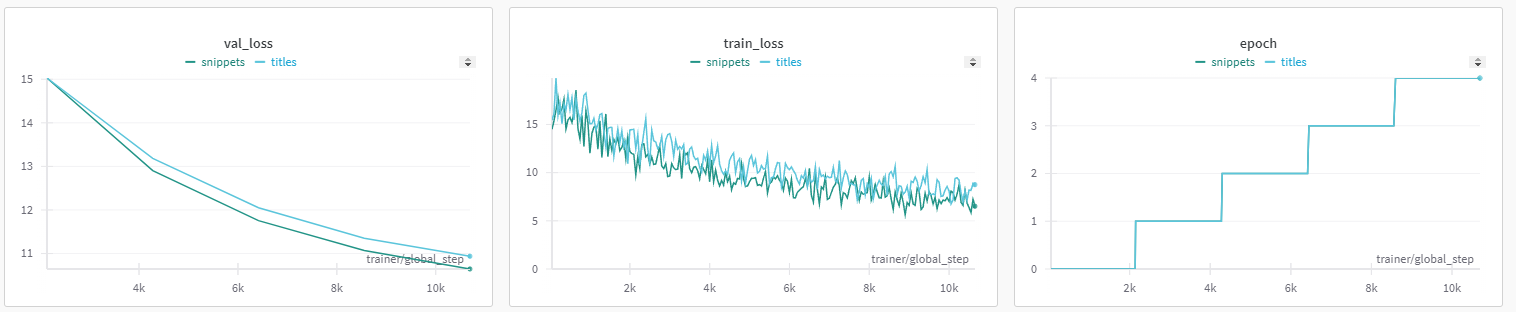

### 1.5 Инференс и оценка качества моделей

Для каждой новости нам надо предсказывать несколько тэгов. То есть в нашем случае настоящее значение таргета это множество из тэгов $y_i = [tag1, tag2, tag3]$. Прогноз модели также множество из тэгов $\hat y_i = [tag1, tag4]$.

Будем считать метрики качества следующим образом (под $|A|$ имеется в виду мощность множества, то есть число элементов в нём):

$$
Precision = \frac{1}{n} \sum_{i = 1}^n \frac{|y_i \cap \hat{y}_i|}{|\hat{y}_i|}
$$

$$
Recall = \frac{1}{n} \sum_{i = 1}^n \frac{|y_i \cap \hat{y}_i|}{|y_i|}
$$

Также можно считать аналог Accuracy, но это не самая удачная идея, так как у нас в выборке огромное число нулей и эта метрика при любом разумном пороге для принятия решения будет очень высокой.

$$
Exact Match = \frac{1}{n} \cdot \frac{1}{k} \sum_{i = 1}^n \sum_{k=1}^K [y_{ij} = \hat{y}_{ij}]
$$

In [32]:
def precision(target, y_pred):
    num = ((y_pred == 1) & (target == 1)).sum(dim = 1)
    denum = (y_pred == 1).sum(dim = 1)
    return (num / (denum + 1e-5)).mean().item()

def recall(target, y_pred):
    num = ((y_pred == 1) & (target == 1)).sum(dim = 1)
    denum = (target == 1).sum(dim = 1)
    return (num / (denum + 1e-5)).mean().item()

def exact_match(target, y_pred):
    return (1. * (y_pred == target)).mean().item()

Построим прогноз на тестовой выборке.

In [33]:
test_loader = torch.utils.data.DataLoader(titles_test_ds, shuffle = False, batch_size = len(titles_test_ds))
for titles, target in test_loader:
    logit = titles_model(titles)
    pred_prob = torch.nn.functional.softmax(logit, dim = 1)

assert pred_prob.shape[0] == len(titles_test_ds)

Теперь выбирая различное значение порога, мы можем получать разные предсказания. Если взять очень большое значение порога, то метрики сильно просядут, так как во многих документах никакого прогноза не будет построено вообще.

In [34]:
TRESHOLD = 0.01
y_pred = 1 * (pred_prob > TRESHOLD)
print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

Exact Match: 0.995770275592804
Precision: 0.2903725802898407
Recall: 0.7468090057373047


In [35]:
TRESHOLD = 0.05
y_pred = 1 * (pred_prob > TRESHOLD)
print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

Exact Match: 0.9983781576156616
Precision: 0.5278831720352173
Recall: 0.5895718932151794


In [36]:
TRESHOLD = 0.9
y_pred = 1 * (pred_prob > TRESHOLD)

print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

Exact Match: 0.9983201622962952
Precision: 0.0036143080797046423
Recall: 0.0034304645378142595


Дальше мы будем строить довольно много прогнозов. Давайте напишем код для их строительства в виде функции. Обратите внимание, что на модели со снипетом она упадёт. Когда вы доберётесь до строительства прогнозов, функцию придётся немного модернизировать.

In [37]:
def get_predict(model, dataset):
    loader = torch.utils.data.DataLoader(dataset, shuffle = False, batch_size = 64)
    model = model.to(device).eval()
    output_probs = None
    targets = None
    for data in loader:
        for i in range(len(data) - 1):
            data[i] = data[i].to(device)

        with torch.no_grad():
            output = model(*data[:-1])
            output_prob = torch.nn.functional.softmax(output, dim = 1)

        if output_probs is None:
            output_probs = output_prob.detach().cpu()
            targets = data[-1]
        else:
            output_probs = torch.cat([ output_probs, output_prob.detach().cpu() ], dim = 0)
            targets = torch.cat([ targets, data[-1] ], dim = 0)

    assert output_probs.shape[0] == len(dataset)
    assert targets.shape[0] == len(dataset)
    return output_probs, targets

__[0.2 балла] Задание 5:__ Какая метрика для нас в этой задаче важнее? Точность или полнота? Почему?

__ваш ответ:__ \
Ответ, безусловно, зависит от бизнес-задачи, которую мы пытаемся решить нашей моделью. С учётом только той информации, которая дана в задании, я считаю, что precision для нас важнее: лучше, чтобы у новости было мало тегов, все из которых действительно подходят, чем много тегов, большинство из которых не имеют отношения к реальному содержанию. \
Более того, для любых предсказаний можно выбрать порог (например, равный 0), при котором recall равен единице. В такой постановке любая модель работает идеально. Очевидно, это не то, что мы хотим: precision нужно учитывать в любом случае. При необходимости выбора только одной из метрик, целесообразно отдать предпочтение precision.

- Напишите функцию, которая будет подбирать оптимальное значение порога, оптимизирующее выбранную вами метрику.
- Подберите значение порога на валидационной выборке.
- Сравните модель со сниппетами и без сниппетов, используя выбранную вами метрику при оптимальном значении порога на тестовой выборке.
- Какая из них оказалась лучше?

In [38]:
def get_threshold(pred_prob, target, step = 0.002):
    target = target.to(device)
    pred_prob = pred_prob.to(device)
    best_precision = target.new_tensor([ 0. ])
    best_threshold = target.new_tensor([ 0. ])
    for threshold in torch.arange(0, 1, step):
        y_pred = 1 * (pred_prob > threshold)
        prec = precision(target, y_pred)
        if prec > best_precision:
            best_precision = prec
            best_threshold = threshold
    return best_threshold.item(), best_precision, recall(target, 1 * (pred_prob > best_threshold))

In [39]:
get_threshold(*get_predict(titles_model, titles_val_ds))

(0.11800000071525574, 0.7312662601470947, 0.5001657009124756)

In [40]:
get_threshold(*get_predict(snippets_model, snippets_val_ds))

(0.09799999743700027, 0.7360733151435852, 0.5382505655288696)

Модель со снипетами оказалась немного лучше.

__[0.2 балла] Задание 6:__  Постройте прогнозы для отложенной выборки, которая представляет из себя пересечение сайта РИА-новостей и ВКонтакте. Проседает ли на ней качество модели? Насколько сильно?

In [41]:
get_threshold(*get_predict(titles_model, titles_oob_ds))

(0.1120000034570694, 0.552761971950531, 0.4190524220466614)

In [42]:
get_threshold(*get_predict(snippets_model, snippets_oob_ds))

(0.06800000369548798, 0.41586995124816895, 0.35732147097587585)

Проседает, причем достаточно заметно. Интересно, что модель со снипетами показала результат хуже, чем модель без снипетов, несмотря на то, что на валидационной выборке результат противоположный.

### 1.6 Бонусное задание 

Давайте модернизируем наши архитектуры настолько, насколько это возможно.

__[0.5 балла]__ Попробуйте собрать более большую архитектуру. Например, сразу после слоя эмбеддингов вы можете попробовать добавить свёрточные слои (`Conv1D` свёртки). Поиграйте с оптимизатором и тп.

Опишите результаты своих экспериментов ниже. Расскажите, что конкретно вы делали и удалось ли вам улучшить качество модели. Все траектории обучения залоггируйте на WandB.  

__Ваш лог экспериментов:__ \
Будем обучать модель без снипетов. Если учёт снипетов и может дать прирост к качеству, то, скорее всего, незначительный.

Попробуем добавить в архитектуру один свёрточный слой, "смотрящий" на все тройки последовательных слов.

In [43]:
class OneConvolutionClassifier(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)
        self.model = torch.nn.Sequential(
            torch.nn.LazyConv1d(1024, kernel_size = 3), torch.nn.ReLU(), torch.nn.BatchNorm1d(1024),
            torch.nn.AdaptiveAvgPool1d(1), torch.nn.Flatten(), torch.nn.Dropout(0.5), torch.nn.LazyLinear(output_dim)
        )

    def forward(self, titles):
        return self.model(self.embedding(titles).transpose(1, 2))

In [44]:
fix_random()

wandb_logger = pytorch_lightning.loggers.WandbLogger(project = "DL-HW-4", name = "one_convolution")
trainer = pytorch_lightning.Trainer(accelerator = "gpu", max_epochs = EPOCHS, logger = wandb_logger)
one_convolution_model = OneConvolutionClassifier(VOCAB_SIZE, EMBEDDING_DIM, NUM_CLASSES)

train_module = TrainLightningModule(one_convolution_model, LR, criterion)
trainer.fit(train_module, titles_train_loader, titles_val_loader)
wandb.finish()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                     | Params
-------------------------------------------------------
0 | model     | OneConvolutionClassifier | 46.1 M
1 | criterion | CrossEntropyLoss         | 0     
-------------------------------------------------------
46.1 M    Trainable params
0         Non-trainable params
46.1 M    Total params
184.328   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
train_loss,█▆▆▆▅▅▄▄▃▄▃▃▃▃▄▃▂▃▁▂▃▃▂▁▂▃▂▁▁▁▂▂▁▂▂▂▁▂▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▄▂▁▁
epoch,4
train_loss,5.99364
trainer/global_step,10694
val_loss,10.82655


In [45]:
print(get_threshold(*get_predict(one_convolution_model, titles_val_ds)))
print(get_threshold(*get_predict(one_convolution_model, titles_oob_ds)))

(0.1459999978542328, 0.7445623278617859, 0.503922700881958)
(0.15399999916553497, 0.5701489448547363, 0.39625802636146545)


Попробуем сделать два последовательных свёрточных слоя.

In [46]:
class SequentialConvolutionsClassifier(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)
        self.model = torch.nn.Sequential(
            torch.nn.LazyConv1d(1024, kernel_size = 3), torch.nn.ReLU(), torch.nn.BatchNorm1d(1024),
            torch.nn.LazyConv1d(1024, kernel_size = 3), torch.nn.ReLU(), torch.nn.BatchNorm1d(1024),
            torch.nn.AdaptiveAvgPool1d(1), torch.nn.Flatten(), torch.nn.Dropout(0.5), torch.nn.LazyLinear(output_dim)
        )

    def forward(self, titles):
        return self.model(self.embedding(titles).transpose(1, 2))

In [47]:
fix_random()

wandb_logger = pytorch_lightning.loggers.WandbLogger(project = "DL-HW-4", name = "sequential_convolutions")
trainer = pytorch_lightning.Trainer(accelerator = "gpu", max_epochs = EPOCHS, logger = wandb_logger)
sequential_convolutions_model = SequentialConvolutionsClassifier(VOCAB_SIZE, EMBEDDING_DIM, NUM_CLASSES)

train_module = TrainLightningModule(sequential_convolutions_model, LR, criterion)
trainer.fit(train_module, titles_train_loader, titles_val_loader)
wandb.finish()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                             | Params
---------------------------------------------------------------
0 | model     | SequentialConvolutionsClassifier | 46.1 M
1 | criterion | CrossEntropyLoss                 | 0     
---------------------------------------------------------------
46.1 M    Trainable params
0         Non-trainable params
46.1 M    Total params
184.336   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
train_loss,█▆▇▆▅▆▅▄▄▅▃▃▃▃▅▃▂▃▁▂▃▃▂▁▂▃▁▁▁▁▂▂▁▁▁▂▁▂▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▂▁▁▁
epoch,4
train_loss,6.11213
trainer/global_step,10694
val_loss,11.05747


In [48]:
print(get_threshold(*get_predict(sequential_convolutions_model, titles_val_ds)))
print(get_threshold(*get_predict(sequential_convolutions_model, titles_oob_ds)))

(0.14799998700618744, 0.7327661514282227, 0.49660077691078186)
(0.12200000137090683, 0.5555276274681091, 0.44819459319114685)


Значительного улучшения не наблюдается, но модель явно стала быстро переобучаться.

Попробуем использовать два свёрточных слоя параллельно.

In [49]:
class ParallelConvolutionsClassifier(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)
        self.conv1 = torch.nn.Sequential(torch.nn.LazyConv1d(1024, kernel_size = 3), torch.nn.ReLU(), torch.nn.BatchNorm1d(1024), torch.nn.AdaptiveAvgPool1d(1), torch.nn.Flatten())
        self.conv2 = torch.nn.Sequential(torch.nn.LazyConv1d(1024, kernel_size = 2), torch.nn.ReLU(), torch.nn.BatchNorm1d(1024), torch.nn.AdaptiveAvgPool1d(1), torch.nn.Flatten())
        self.fc = torch.nn.Sequential(torch.nn.Dropout(0.5), torch.nn.LazyLinear(output_dim))

    def forward(self, titles):
        embeddings = self.embedding(titles).transpose(1, 2)
        features1 = self.conv1(embeddings)
        features2 = self.conv2(embeddings)
        return self.fc(torch.cat([ features1, features2 ], dim = 1))

In [50]:
fix_random()

wandb_logger = pytorch_lightning.loggers.WandbLogger(project = "DL-HW-4", name = "parallel_convolutions")
trainer = pytorch_lightning.Trainer(accelerator = "gpu", max_epochs = EPOCHS, logger = wandb_logger)
parallel_convolutions_model = ParallelConvolutionsClassifier(VOCAB_SIZE, EMBEDDING_DIM, NUM_CLASSES)

train_module = TrainLightningModule(parallel_convolutions_model, LR, criterion)
trainer.fit(train_module, titles_train_loader, titles_val_loader)
wandb.finish()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                           | Params
-------------------------------------------------------------
0 | model     | ParallelConvolutionsClassifier | 46.1 M
1 | criterion | CrossEntropyLoss               | 0     
-------------------------------------------------------------
46.1 M    Trainable params
0         Non-trainable params
46.1 M    Total params
184.336   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
train_loss,█▅▆▆▅▅▄▄▃▄▃▃▃▃▅▃▂▂▁▂▃▃▂▁▂▃▂▁▁▁▂▂▁▂▂▂▁▂▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▂▁▂▂
epoch,4
train_loss,5.93842
trainer/global_step,10694
val_loss,10.96312


In [51]:
print(get_threshold(*get_predict(parallel_convolutions_model, titles_val_ds)))
print(get_threshold(*get_predict(parallel_convolutions_model, titles_oob_ds)))

(0.16200000047683716, 0.7474231719970703, 0.48423105478286743)
(0.1599999964237213, 0.57053142786026, 0.38663655519485474)


![Alternative Text][1702909965293]

[1702909965293]: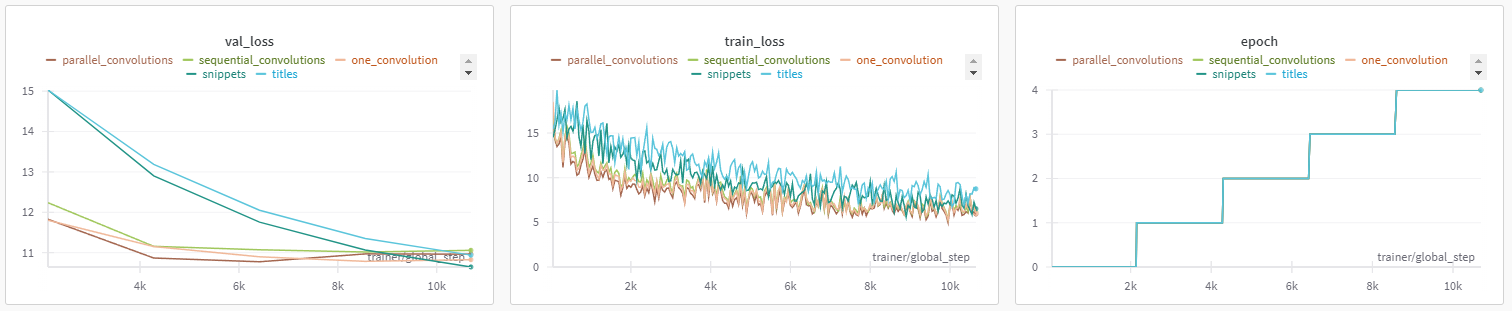

__[0.5]__ Скачайте с сайта [Rusvectores](https://rusvectores.org/ru/models/) любые новостные word2vec эмбединги. Возьмите из модели эмбеддинги для всех слов, которые встречаются вв вашем словаре и добавьте их в модель первым слоем. Заморозьте этот слой и не обновляйте в нём веса. Если у вас в словаре есть слово, но его нет среди предобученных эмбеддингов, замените его на токен `#UNKN`.

__Ваш лог экспериментов:__

-
-
-

In [52]:
# your code here
# =^･ｪ･^=

__[1 балл]__ Зафайнтьюньте трансформер для решения задачи с помощью библиотеки `hugging face`. Выбор предобученной модели кратко обоснуйте.

__Ваш лог экспериментов:__

-
-
-

In [53]:
# your code here
# ٩(ˊ〇ˋ*)و


Сравните все обученные модели между собой на тестовой выборке.

In [54]:
print(get_threshold(*get_predict(titles_model, titles_test_ds)))
print(get_threshold(*get_predict(snippets_model, snippets_test_ds)))
print(get_threshold(*get_predict(one_convolution_model, titles_test_ds)))
print(get_threshold(*get_predict(sequential_convolutions_model, titles_test_ds)))
print(get_threshold(*get_predict(parallel_convolutions_model, titles_test_ds)))

(0.10999999940395355, 0.5796090960502625, 0.4609474837779999)
(0.085999995470047, 0.5514487624168396, 0.459168016910553)
(0.14799998700618744, 0.5921931862831116, 0.44103917479515076)
(0.14999999105930328, 0.5893456339836121, 0.43953534960746765)
(0.14799998700618744, 0.5968402028083801, 0.4447507858276367)


## Часть 2: предсказание категорий (0.3 балла)

Возьмите датасет `df_vk` и для всех новостей из него предскажите категории с помощью лучшей, получившейся у вас модели.

In [105]:
vk_ds = torch.utils.data.TensorDataset(titles_train_ds.create_text(df_vk.title_clean.values, 60))
vk_loader = torch.utils.data.DataLoader(vk_ds, shuffle = False, batch_size = 64)

best_threshold, _, __ = get_threshold(*get_predict(parallel_convolutions_model, titles_test_ds))
parallel_convolutions_model.eval()
vk_tags = [ ]

for (titles,) in tqdm.tqdm(vk_loader):
    with torch.no_grad():
        output = parallel_convolutions_model(titles.to(device))
        pred_prob = torch.nn.functional.softmax(output, dim = 1)
    # Maybe inefficient, but it's fine
    for i in range(pred_prob.shape[0]):
        idxs = torch.nonzero(pred_prob[i] > best_threshold).flatten().tolist()
        vk_tags.append(', '.join(map(lambda idx: idx2tag[idx], idxs)))

df_vk['target_tags'] = vk_tags
df_vk.head()

100%|██████████| 312/312 [00:04<00:00, 66.13it/s]


,id,href,datetime,title,likes,comments,snippet,title_clean,snippet_clean,target_tags
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,NaN,в днр заявили о задержании диверсантов причаст...,#UNK#,в мире
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,NaN,житель урала заминировал тц изза снятия сотов...,#UNK#,происшествия
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,NaN,в черном море нашли потерянный флот гитлера,#UNK#,происшествия
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,NaN,в сша освободили задержанную российскую актрис...,#UNK#,"сша, россия"
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,NaN,толкнувший скабееву депутат рады заявил о гроз...,#UNK#,в мире


На всякий случай сохраните табличку с получившимися у вас предсказаниями. Мало ли, вы не доделаете последнее задание, а потом захотите вернуться к нему. Не прогонять же обучение нейросети и инференс по второму кругу...

In [108]:
df_vk.to_csv("data/predicted_vk.csv")

## Часть 3: сентимент-классификатор (0.5 балла)

В этой части тетрадки нам предстоит прогнать все комментарии из ВК через сентимент-классификатор. Мы будем делать это с помощью библиотеки HuggingFace. В ней есть удобная [функциональность pipline,](https://huggingface.co/docs/transformers/pipeline_tutorial) чтобы прогонять на своих данных уже обученные модели. 🤗🤗🤗

In [114]:
df_comments.head()

,id,post_id,datetime,text,likes
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0


Для классификации комментариев на позитивные, негативные и нейтральные будем использовать [модель, о которой можно почитать по ссылке](https://huggingface.co/seara/rubert-tiny2-russian-sentiment)

Ответьте на следующие вопросы:

1. Как зовут автора модели?
2. Как выглядит архитектура модели? Насколько модель большая?
3. На каких данных обучена модель? Адекватно ли использовать её для классификации комментариев ВК?

Разберитесь как можно прогнать модель на корпусе комментариев и сделайте это. Да, с помощью pipeline можно запустить довольно сложные модели, обученные другими людьми в пару строчек. При объявлении модели не забудьте положить её на нужный `device` 🤗🤗🤗

In [2]:
# Get the model
MODEL_BATCH_SIZE = 12
LOOP_BATCH_SIZE = 12000
MODEL = "seara/rubert-tiny2-russian-sentiment"
model = transformers.pipeline(model = MODEL, device = device, batch_size = MODEL_BATCH_SIZE, truncation = True)

In [6]:
print("Author name: seara")

Author name: seara


In [7]:
print(model.model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, 

In [11]:
print('Parameters:', sum(p.numel() for p in model.model.parameters()))

Parameters: 29194707


Модель обучена на датасете rureviews, состоящем из русскоязычных комментариев из онлайн-магазинов. В целом, датасет достаточно похож на комментарии в ВК.

In [ ]:
# Split into batches by hand to get a progress bar
comments = df_comments.text.values
batches = numpy.array_split(comments, (len(comments) + (LOOP_BATCH_SIZE - 1)) / LOOP_BATCH_SIZE)
assert len(comments) == numpy.sum([ *map(len, batches) ])

labels = numpy.array([])
scores = numpy.array([])
for batch in tqdm.tqdm(batches):
    batch_predictions = model(batch.tolist())
    batch_labels = list(map(lambda item: item['label'], batch_predictions))
    batch_scores = list(map(lambda item: item['score'], batch_predictions))
    labels = numpy.append(labels, batch_labels)
    scores = numpy.append(scores, batch_scores)

print(len(labels), len(scores))
assert len(comments) == len(labels)
assert len(comments) == len(scores)

# Оно работает, я случайно очистил вывод :(
# Ниже демонстрация на небольшом количестве комментариев

In [117]:
# Split into batches by hand to get a progress bar
def demo():
    comments = df_comments.text.values[:100]
    batches = numpy.array_split(comments, (len(comments) + (24 - 1)) / 24)
    assert len(comments) == numpy.sum([ *map(len, batches) ])

    labels = numpy.array([])
    scores = numpy.array([])
    for batch in tqdm.tqdm(batches):
        batch_predictions = model(batch.tolist())
        batch_labels = list(map(lambda item: item['label'], batch_predictions))
        batch_scores = list(map(lambda item: item['score'], batch_predictions))
        labels = numpy.append(labels, batch_labels)
        scores = numpy.append(scores, batch_scores)

    print(len(labels), len(scores))
    print(labels, scores)
    assert len(comments) == len(labels)
    assert len(comments) == len(scores)
demo()

100%|██████████| 5/5 [00:00<00:00, 21.14it/s]

100 100
['neutral' 'neutral' 'positive' 'neutral' 'neutral' 'neutral' 'neutral'
 'neutral' 'neutral' 'neutral' 'neutral' 'neutral' 'neutral' 'neutral'
 'negative' 'neutral' 'negative' 'negative' 'neutral' 'neutral' 'neutral'
 'positive' 'neutral' 'neutral' 'neutral' 'neutral' 'negative' 'neutral'
 'neutral' 'neutral' 'neutral' 'neutral' 'negative' 'neutral' 'neutral'
 'negative' 'negative' 'negative' 'neutral' 'neutral' 'neutral' 'neutral'
 'neutral' 'neutral' 'neutral' 'negative' 'negative' 'positive' 'neutral'
 'neutral' 'negative' 'neutral' 'neutral' 'neutral' 'neutral' 'negative'
 'negative' 'neutral' 'neutral' 'neutral' 'negative' 'negative' 'neutral'
 'negative' 'negative' 'neutral' 'neutral' 'neutral' 'neutral' 'negative'
 'neutral' 'positive' 'neutral' 'neutral' 'negative' 'neutral' 'negative'
 'neutral' 'neutral' 'negative' 'neutral' 'neutral' 'neutral' 'neutral'
 'positive' 'neutral' 'neutral' 'neutral' 'neutral' 'negative' 'neutral'
 'neutral' 'neutral' 'neutral' 'neutral' '

Цикл для сентимент-анализа комментариев может работать довольно долго. Я крайне рекомендую вам переодически сохранять к себе на компьютер промежуточные результаты. Итоговый результат я рекомендую записать отдельным столбиком в таблицу с комментариями, а затем сохранить полученные результаты. 🤗🤗🤗

In [ ]:
df_comments['sentiment_verdict'] = labels
df_comments['sentiment_score'] = scores
df_comments

In [ ]:
df_comments.to_csv("data/comments_scored.csv")

## Часть 4: аналитика (1 балл + 0.2 бонусных)

Мы с вами огромные молодцы. Мы обучили модель для категоризации новостей, построили с её помощью прогнозы. Мы проскорили комментарии на их сентимент-окрас. Теперь давайте проанализируем новости. Описывайте полученные результаты таким образом, чтобы не получить уголовку на 5 лет за дискредитацию чего-нибудь или оскорбление чувств кого-нибудь 💜

In [118]:
df_comments = pandas.read_csv('data/comments_scored.csv')
print(df_comments.shape)
df_comments.head()

(2612629, 8)


,Unnamed: 0,id,post_id,datetime,text,likes,sentiment_verdict,sentiment_score
0,0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0,neutral,0.912246
1,1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0,neutral,0.879370
2,2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0,positive,0.676261
3,3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0,neutral,0.925939
4,4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0,neutral,0.866223


In [119]:
df_comments_positive = df_comments[df_comments.sentiment_verdict == "positive"]
df_comments_neutral = df_comments[df_comments.sentiment_verdict == "neutral"]
df_comments_negative = df_comments[df_comments.sentiment_verdict == "negative"]
assert len(df_comments_positive) + len(df_comments_neutral) + len(df_comments_negative) == len(df_comments)

__[0.2 балла]__ Какая доля комментариев позитивная? Какая доля комментариев негативная? Выведите 10 самых позитивных комментариев.

Выведите 10 самых негативных комментариев, поугарайте с них. Удалите их вывод из тетрадки. Никто не должен их видеть, это должно остаться только между нами. Поззитивные не удаляйте. Они пусть останутся.

In [120]:
print("Positive part:", len(df_comments_positive) / len(df_comments))
print("Negative part:", len(df_comments_negative) / len(df_comments))
df_comments_positive.sort_values(by = "sentiment_score", ascending = False).head(10)

Positive part: 0.07200180354730809
Negative part: 0.22879865453533585


,Unnamed: 0,id,post_id,datetime,text,likes,sentiment_verdict,sentiment_score
493792,508965,23095070.0,23094261.0,2018-11-17 11:21:56,"Отлично, молодец!Поздравляю!✨💫🌟💥",0.0,positive,0.996725
1379447,1424111,21323499.0,21322970.0,2018-06-20 18:54:40,Отлично! Просто отлично! Молодцы! Поздравляю о...,3.0,positive,0.996674
2352264,2434524,18718201.0,18718179.0,2017-11-30 13:22:42,"отлично,молодцы!!!👍 респект",3.0,positive,0.996605
2057938,2128990,19643844.0,19640879.0,2018-02-16 08:33:19,Отлично! \nПоздравляем!!!,1.0,positive,0.996536
2074701,2146325,19591344.0,19588477.0,2018-02-12 08:25:08,"Отлично,я рад.",0.0,positive,0.996462
236794,243929,23585686.0,23584622.0,2018-12-29 11:48:39,"Отлично,молодцы",2.0,positive,0.996461
1300899,1342337,21515168.0,21514312.0,2018-07-06 15:22:04,"Отлично,люблю ездить в Эмираты",0.0,positive,0.996450
288287,296711,23487341.0,23487299.0,2018-12-20 12:34:50,Отлично! Здоровья всем желаю!,8.0,positive,0.996444
411428,423821,23248899.0,23242108.0,2018-11-30 07:31:37,Я очень счастлива! Поздравляю!,0.0,positive,0.996431
1681663,1737559,20633834.0,20633609.0,2018-04-25 10:13:42,"Отлично, просто отлично!",0.0,positive,0.996418


__[0.2 балла]__ Для каждой новости из датасета посчитайте количество негативных и позитивных комментариев под ней. Сохраните эти количества в виде новых колонок.

In [121]:
def add_comments(dest: pandas.DataFrame, src: pandas.DataFrame, name: str):
    counts = src[["id", "post_id"]].groupby(by = [ "post_id" ]).count().rename(columns = { 'id': name })
    dest = dest.merge(counts, how = 'left', left_on = 'id', right_on = 'post_id', validate = 'one_to_one')
    dest[[name]] = dest[[name]].fillna(value = 0)
    return dest

df_vk_comments = add_comments(df_vk, df_comments_positive, "positive")
df_vk_comments = add_comments(df_vk_comments, df_comments_neutral, "neutral")
df_vk_comments = add_comments(df_vk_comments, df_comments_negative, "negative")
df_vk_comments["total"] = df_vk_comments.positive.values + df_vk_comments.neutral.values + df_vk_comments.negative.values
df_vk_comments.head()

,id,href,datetime,title,likes,comments,snippet,title_clean,snippet_clean,target_tags,positive,neutral,negative,total
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,NaN,в днр заявили о задержании диверсантов причаст...,#UNK#,в мире,2.0,35.0,10.0,47.0
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,NaN,житель урала заминировал тц изза снятия сотов...,#UNK#,происшествия,3.0,28.0,11.0,42.0
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,NaN,в черном море нашли потерянный флот гитлера,#UNK#,происшествия,3.0,15.0,4.0,22.0
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,NaN,в сша освободили задержанную российскую актрис...,#UNK#,"сша, россия",2.0,28.0,10.0,40.0
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,NaN,толкнувший скабееву депутат рады заявил о гроз...,#UNK#,в мире,10.0,93.0,37.0,140.0


__[0.2 балл]__ Правда ли, что новости с большим количеством лайков получают больше негативных комментариев? А позитивных? Правда ли, что чем больше лайков, тем под новостью больше комментариев?

Постройте визуализацию, которая могла бы это проиллюстрировать.

Likes - negative comments correlation: 0.10144554068367093
Likes - positive comments correlation: 0.5812735834217725
Likes - total comments correlation: 0.2012393732898615


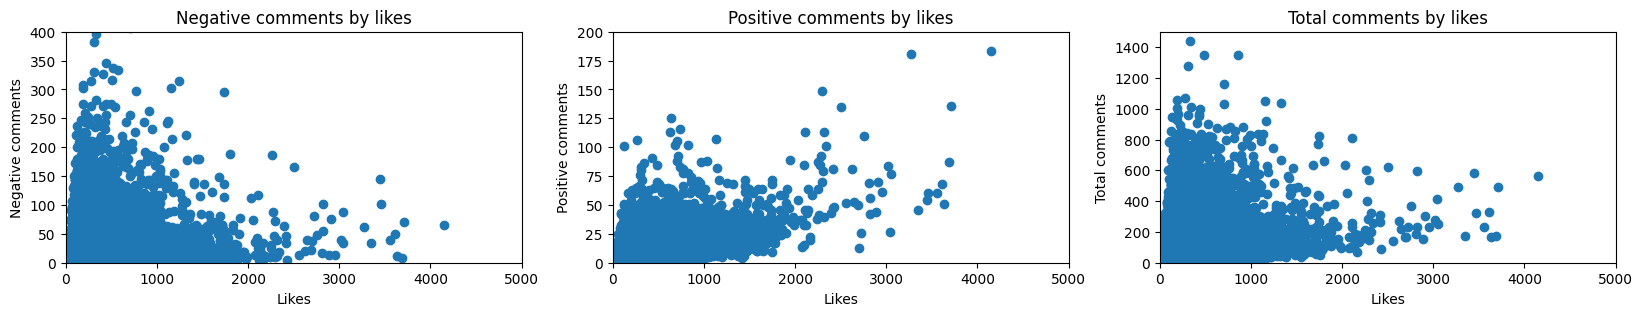

In [122]:
plt.figure(figsize = (20, 3))

plt.subplot(1, 3, 1)
plt.xlim((0, 5000))
plt.ylim((0, 400))
plt.xlabel("Likes")
plt.ylabel("Negative comments")
plt.title("Negative comments by likes")
plt.scatter(df_vk_comments.likes, df_vk_comments.negative)
print('Likes - negative comments correlation:', df_vk_comments.likes.corr(df_vk_comments.negative))

plt.subplot(1, 3, 2)
plt.xlim((0, 5000))
plt.ylim((0, 200))
plt.xlabel("Likes")
plt.ylabel("Positive comments")
plt.title("Positive comments by likes")
plt.scatter(df_vk_comments.likes, df_vk_comments.positive)
print('Likes - positive comments correlation:', df_vk_comments.likes.corr(df_vk_comments.positive))


plt.subplot(1, 3, 3)
plt.xlim((0, 5000))
plt.ylim((0, 1500))
plt.xlabel("Likes")
plt.ylabel("Total comments")
plt.title("Total comments by likes")
plt.scatter(df_vk_comments.likes, df_vk_comments.total)
print('Likes - total comments correlation:', df_vk_comments.likes.corr(df_vk_comments.total))

plt.show()

`Правда ли, что новости с большим количеством лайков получают больше негативных комментариев?` \
Точно нет. Корреляция всего лишь 0.1 \
`А позитивных?` \
Возможно, да. Корреляция почти 0.6 \
`Правда ли, что чем больше лайков, тем под новостью больше комментариев?` \
Скорее нет. Корелляция 0.2

__[0.2]__  Давайте построим по сентимент-окрасу комментариев топ позитивных новостей.

- Если под новостью оставлено 100 комментариев, из которых 80 позитивные, мы можем быть уверены в том, что новость была хорошо воспринята людьми.
- Если под новостью всего один комментарий и он оказался позитивным, то у нас 100% позитивных комментариев, но это вовсе не означает, что новость была воспринята хорошо.

Получается, что сортировать по доле позитивных комментариев нельзя. Давайте поступим умнее. Доля позитивных комментариев под постом -- это случайная величина. Её довольно часто моделируют с помощью бета-распределения. Если это случайная величина, мы можем построить для неё предиктивный интервал. Пусть $u$ - число позитивных комментариев, а $d$ - нейтральных и негативных.  Пусть

$$
a = 1 + u \qquad b = 1 + d.
$$

Тогда нижняя граница $95\%$ предиктивного интервала для доли будет вычисляться по такой формуле:

$$
\frac{a}{a + b} - 1.65 \cdot \sqrt{\frac{a \cdot b}{(a + b)^2 \cdot (a + b + 1)}}
$$

Если под новостью был всего один комментарий, у такой случайной величины будет высокая дисперсия. Это означаen, что штука, которую мы вычитаем из доли, окажется высокой. Левая граница интервала окажется маленькой и мы не поднимем комментарий в нашем топе наверх. Фактически мы делаем сортировку по квантилю уровня $0.05$ вместо среднего.

От вас требуется вбить эту формулу, сделать сортировку и вывести на экран топ позитивных новостей. Подробнее про то, откуда берётся эта формула можно почитать [в этой книге.](https://disk.yandex.ru/i/Ctd08bTwC9eI3g) Ищите 4 главу, страницу 140.

In [123]:
a = 1 + df_vk_comments.positive.values
b = 1 + df_vk_comments.neutral.values + df_vk_comments.negative.values
center = (a / (a + b))
offset = (a * b) / (numpy.power(a + b, 2) * (a + b + 1))
df_vk_comments['score'] = center - 1.65 * numpy.sqrt(offset)
df_vk_comments.sort_values(by = 'score', ascending = False).drop(columns = [ 'href', 'comments' ]).head()

,id,datetime,title,likes,snippet,title_clean,snippet_clean,target_tags,positive,neutral,negative,total,score
6651,22320852,2018-09-13 16:40:33,Сборная России выиграла командный турнир на че...,1387,NaN,сборная россии выиграла командный турнир на че...,#UNK#,художественная гимнастика,34.0,16.0,0.0,50.0,0.566760
14020,20027260,2018-03-16 03:54:32,"Миленина выиграла биатлонную гонку на 12,5 км,...",1106,Россиянка Анна Миленина завоевала седьмое золо...,миленина выиграла биатлонную гонку на 125 км с...,россиянка анна миленина завоевала седьмое золо...,"сборная россии - пхенчхан 2018, паралимпийские...",16.0,8.0,0.0,24.0,0.502777
6620,22326485,2018-09-14 07:55:44,Россиянки заняли третье место в ските среди юн...,359,NaN,россиянки заняли третье место в ските среди юн...,#UNK#,стрелковый спорт,10.0,4.0,0.0,14.0,0.502010
13735,20128079,2018-03-23 07:19:58,Россиянка Мельникова победила в многоборье на ...,670,NaN,россиянка мельникова победила в многоборье на ...,#UNK#,спортивная гимнастика,10.0,4.0,0.0,14.0,0.502010
12529,20591225,2018-04-22 16:30:18,"""Ак Барс"" стал трехкратным обладателем Кубка Г...",1292,NaN,ак барс стал трехкратным обладателем кубка гаг...,#UNK#,"спорт, хоккей",42.0,26.0,3.0,71.0,0.494670


Построили? Срочно пришлите свою любимую позитивную  новость в общий чат!!!

Топ негативных новостей строить не будем. Вокруг итак слишком много негатива 😻😻😻

__[0.2]__ Какие категории новостей оказались самыми позитивными? Придумайте способ найти такие категории и опишите его тут.

__Ответ:__ усредним значения, полученные в прошлом задании, по категориям. Чем более позитивные новости в категории, тем больше будет среднее. Таким образом, самыми позитивными категориями будем считать те, у которых наибольшее среднее значение "позитивности" новостей.

In [176]:
df_tag_scores =  [ ]
for (_, item) in df_vk_comments.iterrows():
    if not item["target_tags"]: continue
    for tag in item["target_tags"].split(', '):
        df_tag_scores.append([ tag, item['score'] ])
df_tag_scores = pandas.DataFrame(df_tag_scores, columns = [ 'tag', 'score' ])
df_tag_scores.groupby(by = "tag").mean().reset_index().sort_values(by = "score", ascending = False).head(10)

,tag,score
742,тайвань,0.360550
15,iaaf,0.307278
831,художественная гимнастика,0.300713
606,регби,0.300370
71,андрей дементьев,0.263808
390,культура - риа новости. итоги дня,0.262243
551,паралимпийские игры - пхенчхан 2018,0.252715
566,пляжный футбол,0.234086
662,сборная россии - пхенчхан 2018,0.233878
596,пхенчхан 2018,0.233283


__[0.2 бонусных]__ Проанализируйте, как температура комментария (вероятность того, что он негативный) зависит от длины трэда (число комментариев под новостью)? Значима ли эта взаимосвязь? Если вам для проверки этого хочется построить линейную регрессию, не сдерживайтесь.

In [ ]:
# your code here
# ヾ(๑╹◡╹)ﾉ